# The Sluzky-Yule effect

Let us filter a random process with a moving average filter. The random process $x[n]$ is obtained by sampling independently at random a normal random variable with zero mean and variance 1.

Populating the interactive namespace from numpy and matplotlib


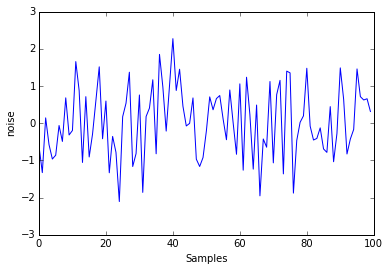

In [1]:
from scipy import signal as sc
import numpy as np
%pylab inline

noise = np.random.normal(0,1,100)
plot(np.arange(noise.size),noise)
xlabel('Samples')
ylabel('noise')
show()

The impulse response of the filter is given by

$ h[n] = \begin{cases} 
1  \ \text{if } 0 \leq n \leq M-1 \\
0 \ \text{otherwise} 
\end{cases}$


The following code computes the moving average for various values of $M$ by convolving the input signal with the filter impulse response using the function conv(.).

In [2]:
M = np.linspace(10,50,5)  # Various lengths of the MA filter 
x = np.random.randn(100,1) # AWGN 100 samples

Random_Conv = [0,1,2,3,4] # container for the filtered signals
for i in range(len(M)):
    current_M = M[i]
    h = 1.0/current_M*np.ones(current_M).reshape(current_M,1) # Create the impulse response of MA filter
    
    Random_Conv[i] = sc.convolve2d(x,h,'valid') # filtered signal with current_M samples

First, note that the output $y$ is of size $M+L−1$ (Recall that $L$ is the size of $h$ and $M$ is the size of $x$). Indeed, remember that when convolving a signal with an impulse response, we flip the impulse response in time and shift it progressively on the right until there is no more overlap between the two signals. There is first $L−1$ points that are formed by a partial overlap of $h$ and $x$, than $M−L+1$ points that are formed by a complete overlap of $h$ and $x$ and, again, $L−1$ points that are formed by a partial overlap of $h$ and $x$. Let us now display the result for various values of $M$, the length of the filter.

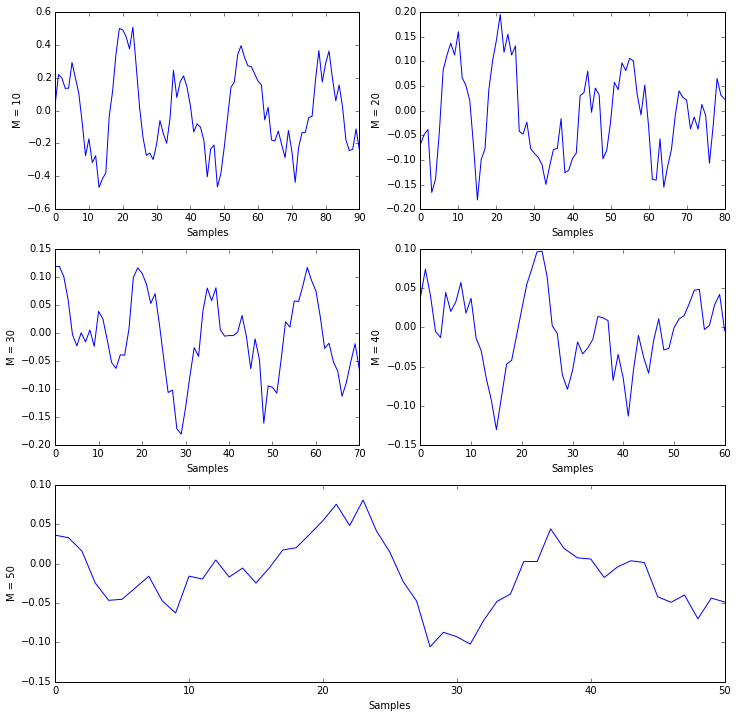

In [3]:
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

subplot(3,2,1)
plot(np.arange(Random_Conv[0].size),Random_Conv[0])
ylabel('M = 10'), xlabel('Samples')

subplot(3,2,2)
plot(np.arange(Random_Conv[1].size),Random_Conv[1])
ylabel('M = 20'), xlabel('Samples')

subplot(3,2,3)
plot(np.arange(Random_Conv[2].size),Random_Conv[2])
ylabel('M = 30'), xlabel('Samples')

subplot(3,2,4)
plot(np.arange(Random_Conv[3].size),Random_Conv[3])
ylabel('M = 40'), xlabel('Samples')

subplot(3,2,(5,6))
plot(np.arange(Random_Conv[4].size),Random_Conv[4])
ylabel('M = 50'), xlabel('Samples')
show()

We observe that, as $M$ increases, a cycle appears in the process. Whereas the original signal is random and very difficult to predict, the filtered signal appears very predictable as it contains a cycle! Imagine that the original process is the return of a stock, have we find a method to predict it? The answer is (unfortunately) no. The cycle is just a spurious effect known as the Slutzky-Yule effect. Although moving average is a commonly used tool to denoise a signal, we should remember that it creates spurious effects for large $M$ or when applying the filter repeatedly.

# Measuring Financial Risk

The goal of this example is to apply the concept of filters seen in the lecture to compute commonly used risk measures in finance. Consider the following problem faced by an investor who is interested in a certain stock whose evolution of the price $p[t]$ over $5$ years sampled at daily frequency is obtained using the following code and depicted in the figure below.

In [5]:
import scipy.io as sio
% pylab inline

# Parameters (used for MA and leaky integrator filters)
M = 100
LAMBDA = 0.94

# Load data
mat_contents = sio.loadmat('D:/TrabajoSwIng/Python/IPython Notebooks/DSPNumex_EPFL/NumEx5/data.mat')
print(mat_contents)

Populating the interactive namespace from numpy and matplotlib
{'__globals__': [], '__version__': '1.0', 'price_ts': array([[ 160.8153],
       [ 159.2794],
       [ 157.181 ],
       ..., 
       [ 112.1756],
       [ 108.7871],
       [ 107.4085]]), 'dates_ts': array([[ 20060711.],
       [ 20060712.],
       [ 20060713.],
       ..., 
       [ 20110708.],
       [ 20110711.],
       [ 20110712.]]), '__header__': b'MATLAB 5.0 MAT-file, Created on: Wed Jan 23 10:12:12 2013\n by FreeMat v4.1'}


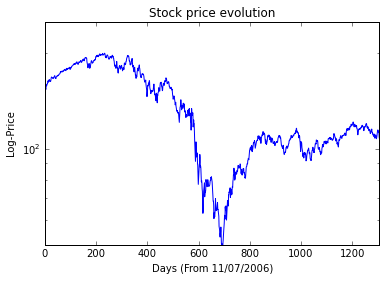

In [7]:
# Dates
dates = mat_contents['dates_ts']
dates = dates.reshape(dates.size,)
# Prices
price = mat_contents['price_ts']
price = price.reshape(price.size,)

#for logarithmic plotting use pylab.semilogy
dates_n = np.arange(dates.size)
semilogy(dates_n,price)
ylim([50,250]), xlim([0,1305])
xlabel('Days (From 11/07/2006)'), ylabel('Log-Price'), title('Stock price evolution')
show()

More than the price, an investor is interested in the return $r[t]$ of his investment, defined as:
$$r[t] = \frac{p[t] - p[t-1]}{p[t]}$$

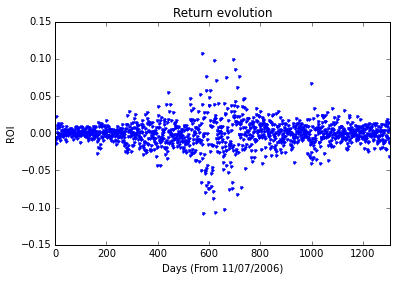

In [4]:
# Compute simple return time-series
return_ts = (price[1:price.size] - price[0:(price.size-1)])/price[1:price.size]
dates_ts = dates[2:dates.size]
length_ts = len(return_ts)

#For small point plotting use pylab.plot with '.' option
plot(np.arange(return_ts.size),return_ts,'.')
xlabel('Days (From 11/07/2006)'), ylabel('ROI'), title('Return evolution')
xlim([0,1305])
show()

At the same time, an investor would like to assess the risk of his investment. Since the seminal work of Markowitz, this is done (imperfectly) by measuring the volatility or, in signal processing terms, the standard deviation of returns. The volatility is not directly observable and must be estimated. We now see how the paradigm of filters can be applied to compute several estimates of volatility.

### The moving average filter

Let us come back to the problem of measuring the volatility. A first way of measuring it is to compute its value over the last M observations of returns. Let us first define the average return $\bar{r}[t]$ over the last $M$ observations:

$$\bar{r}[t] = \frac{1}{M}\sum_{k=0}^{M-1} r(t-k)$$

In other terms, this is the convolution of the return signal with the moving average filter. The volatility is then given by

$$\sigma^2[t] = \frac{1}{M} \sum_{k=0}^{M−1} (r[t−k]−\bar{r}[t])^2$$

$$\sigma[t]= \sqrt{\sigma^2[t]}$$

Again, this formula can be interpreted in terms of filtering. It is the convolution between the moving average filter with the process that is obtained by squaring the difference between contemporaneous return and the $M$ point moving average return.

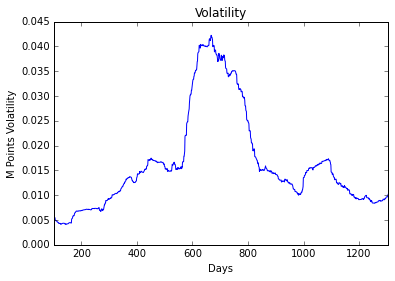

In [8]:
# Compute the M-point volatility
import numpy as np

volatility = np.zeros(length_ts)
h = 1.0/float(M)*np.ones(M,dtype=float)

for i in range(M,length_ts):
    temp = return_ts[(i-M):i]       # This is equivalent to r[t-k]
    moving_average = np.dot(h,temp) # This is the sum to get bar{r}!
    volatility[i] = np.dot(h,pow(temp-moving_average,2))
    
volatility = np.sqrt(volatility)

plot(np.arange(volatility.size),volatility)
xlabel('Days'), ylabel('M Points Volatility'), title('Volatility')
xlim([100,1305])
show()

### The leaky integrator

In the previous formula, when computing the average return or volatility, the same weight is given to each observation $(1/M)$. Since more recent observations are more relevant to predict the future, we can consider instead the exponentially weighted volatility, given by the formula:

$$\bar{r}[t] = \lambda \bar{r}[t-1] + (1 - \lambda)r[t]$$
$$\sigma^2[t] = \lambda\sigma^2[t-1] + (1 - \lambda)(r[t] - \bar{r}[t])^2$$
$$\sigma[t] = \sqrt{\sigma^2[t]}$$

We recognize above the recursive formula of the leaky integrator. Thus, this is again a simple filtering by the impulse response of the leaky integrator. The coefficients of the filter decreases exponentially, hence the name exponentially weighted volatility.

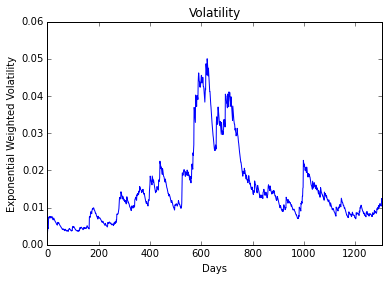

In [9]:
# Compute the exponentially weighted volatility
exp_average = 0
exp_volatility = np.zeros(length_ts + 1)

for i in range(length_ts):
    exp_average = LAMBDA * exp_average + (1 - LAMBDA) * return_ts[i]
    exp_volatility[i + 1] = LAMBDA * exp_volatility[i] + (1 - LAMBDA)*pow(return_ts[i] - exp_average,2)

exp_volatility = np.sqrt(exp_volatility[1:exp_volatility.size])

plot(np.arange(exp_volatility.size),exp_volatility)
xlabel('Days'), ylabel('Exponential Weighted Volatility'), title('Volatility')
xlim([0,1305])
show()

And now run to an economist or actuarian and find if it is good to buy or sell your stock! 